# Fine-tuning a BERT model for text extraction with the SQuAD dataset

We are going to fine-tune BERT for the text-extraction task with a dataset of questions and answers. The question are about a give paragraph (*context*) that contains the answers. The model will be trained to locate the answer in the context by giving the possitions where the answer stars and finish.

This notebook is based on [BERT (from HuggingFace Transformers) for Text Extraction](https://keras.io/examples/nlp/text_extraction_with_bert/).

 More info:
  * [BERT NLP — How To Build a Question Answering Bot](https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b)

In [1]:
import json
import dataset_utils as du
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from transformers import TFBertModel

In [2]:
train_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json"
train_path = keras.utils.get_file("train.json", train_data_url, cache_dir="./")

eval_data_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json"
eval_path = keras.utils.get_file("eval.json", eval_data_url, cache_dir="./")

In [3]:
max_len = 384

with open(train_path) as f:
    raw_train_data = json.load(f)

train_squad_examples = du.create_squad_examples(raw_train_data, max_len)
x_train, y_train = du.create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

with open(eval_path) as f:
    raw_eval_data = json.load(f)

eval_squad_examples = du.create_squad_examples(raw_eval_data, max_len)
x_eval, y_eval = du.create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

87599 training points created.
10570 evaluation points created.


In [5]:
encoder = TFBertModel.from_pretrained("bert-base-uncased",
                                      cache_dir='/scratch/snx3000/sarafael/bert_model')

input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)

embedding = encoder(input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask)[0]

start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
start_logits = layers.Flatten()(start_logits)
start_probs = layers.Activation(keras.activations.softmax)(start_logits)

end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
end_logits = layers.Flatten()(end_logits)
end_probs = layers.Activation(keras.activations.softmax)(end_logits)

model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask],
                    outputs=[start_probs, end_probs])

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = keras.optimizers.Adam(lr=5e-5)

model.compile(optimizer=optimizer, loss=[loss, loss])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the ckeckpoint was trained on, you can already use TFBertModel for predictions without further training.


In [6]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 384)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 384, 768), ( 109482240   input_4[0][0]                    
                                                                 input_6[0][0]         

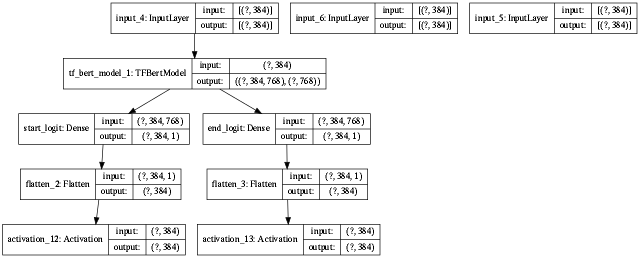

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

In [8]:
def dataset_generator(x=x_train, y=y_train):
    for i in range(x_train[0].shape[0]):
        yield ((x_train[0][i], x_train[1][i], x_train[2][i]),
               (y_train[0][i], y_train[1][i]))

In [9]:
dataset = tf.data.Dataset.from_generator(dataset_generator,
                                         output_types=((tf.int32, tf.int32, tf.int32),(tf.int32, tf.int32)),
                                         output_shapes=(((max_len,), (max_len,), (max_len,)),((), ()))
                                        )
dataset = dataset.batch(16)  # originally 64

In [78]:
fit = model.fit(dataset, epochs=1)

In [80]:
model.save_weights('/scratch/snx3000/sarafael/bert_model_tuned.h5')

In [12]:
model.evaluate(x_eval, y_eval)

323/323 [==============================] - 154s 478ms/step - loss: 2.3509 - activation_12_loss: 1.1685 - activation_13_loss: 1.1824


[2.3509440422058105, 1.168543815612793, 1.182401418685913]

In [56]:
import numpy as np
import string
import re


def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


class ExactMatch():
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval, model, squad_examples):
        self.x_eval = x_eval
        self.y_eval = y_eval
        self.model = model
        self.squad_examples = squad_examples

    def score(self, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in self.squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue

            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
                
            # print(f'  - {squad_eg.question}\n')
            print(f'  - {normalized_pred_ans:30.30s} | ref: {squad_eg.answer_text:30s} | {squad_eg.question}')

        acc = count / len(self.y_eval[0])
        return acc

In [72]:
num_samples = 500
em = ExactMatch([x_eval[0][:num_samples], x_eval[1][:num_samples], x_eval[2][:num_samples]],
                [y_eval[0][:num_samples], y_eval[1][:num_samples]],
                model,
                eval_squad_examples)
em.score()

  - denver broncos                 | ref: Denver Broncos                 | Which NFL team represented the AFC at Super Bowl 50?
  - carolina panthers              | ref: Carolina Panthers              | Which NFL team represented the NFC at Super Bowl 50?
  - santa clara california         | ref: Santa Clara, California        | Where did Super Bowl 50 take place?
  - denver broncos                 | ref: Denver Broncos                 | Which NFL team won Super Bowl 50?
  - golden                         | ref: gold                           | What color was used to emphasize the 50th anniversary of the Super Bowl?
  - gold                           | ref: "golden anniversary"           | What was the theme of Super Bowl 50?
  - february 7 2016                | ref: February 7, 2016               | What day was the game played on?
  - american football conference   | ref: American Football Conference   | What is the AFC short for?
  - gold                           | ref: "golden anni

0.822